<h1 style="text-align: center;" markdown="1">Layer Normalization & Add</h1>



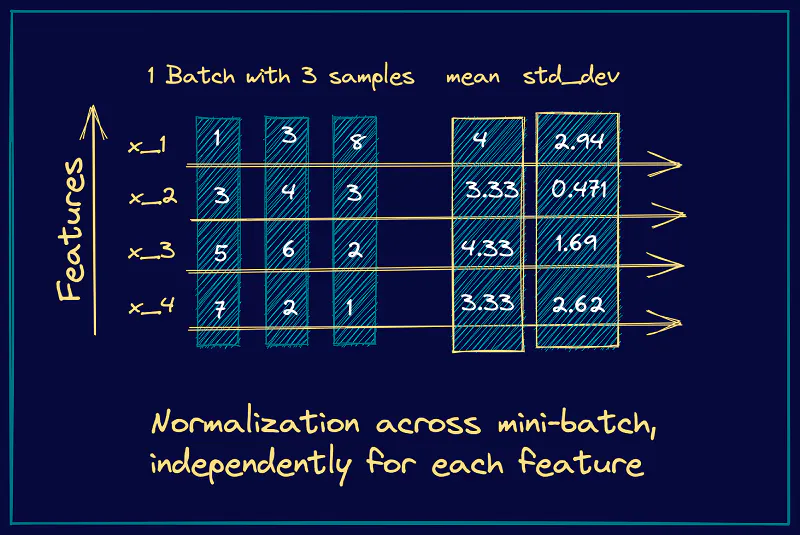

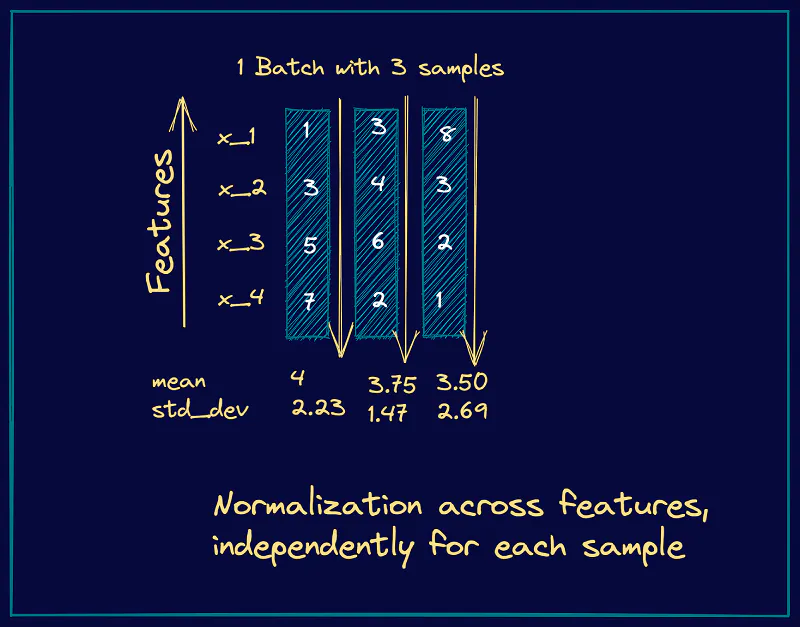

**BatchNorm**: Performance and effectiveness can depend on the size of the batch.

**LayerNorm**: Performance is generally stable and independent of batch size.

### Referred as Add & Norm in NLP
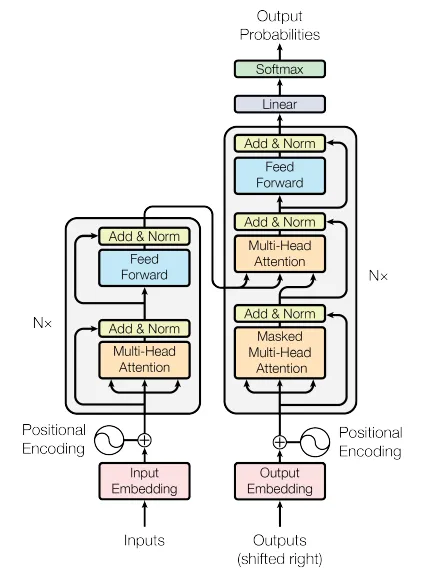

We have two connections to [ADD & NORM]. One is where V X Attention return final output from Multi-head and another is residual connection. These residual connection are there to ensure there are stronger information signals that flows through deep network. This is required because we will notice that during backpropogation there will be vanishing gradients. (gradient updates become zero during back-prop)

_____
So we will add this new V (or Output of M-HA) with X'. Where X' is the matrix which we get after adding positional encoding to emmbeddings.
after this we will normalize this addition.

> So we are doing **ADD** & **NORM**

_____
what normalising does is compat the values of the neuron weights around 0 to get much more stable training by taking even steps during back propgation

> The output of each neuron is activation. These activation can get really large magnitude. This could lead to large training step hence unstable training.

> To mitigate this we will normalize these values by subtracting the mean and dividing by S.D of the layer.

### Formula for Layer Normalization

Layer Normalization standardizes the inputs across features for each individual sample in a batch. The formula for Layer Normalization is given by:

$$ \text{LN}(x) = \frac{x - \mu}{\sigma} \cdot \gamma + \beta $$

Where:
- `x` is the input to a layer of neurons.
- `μ` (mu) is the mean computed across all features of a single training example.
- `σ` (sigma) is the standard deviation computed across all features of that training example.
- `γ` (gamma) and `β` (beta) are parameters to be learned during training, which scale and shift the normalized value, respectively.

This normalization helps to stabilize the distribution of activations throughout the training process, improving the convergence behavior of the model.

In [43]:
import torch
from torch import nn

In [44]:
inputs = torch.Tensor([[[0.2, 0.1, 0.3], [0.5, 0.1, 0.1]]]) # we have added batch dimension also here, now we have 2 words in a batch
B, S, E = inputs.size() # batch, number of words, embedding size
inputs = inputs.reshape(S,B,E) # reshaping to (S,B,E) from (B,S,E)
inputs.size() 

torch.Size([2, 1, 3])

In [45]:
parameter_shape = inputs.size()[-2:] # Shape of the tensor except the last dimension (S,E)
gamma = nn.Parameter(torch.ones(parameter_shape)) # Initially initialize gamma with ones & beta with zeros
beta = nn.Parameter(torch.zeros(parameter_shape))
gamma, beta

(Parameter containing:
 tensor([[1., 1., 1.]], requires_grad=True),
 Parameter containing:
 tensor([[0., 0., 0.]], requires_grad=True))

In [46]:
gamma.size(), beta.size() # Now we have 1 X 3 dimensional matrix 

(torch.Size([1, 3]), torch.Size([1, 3]))

In [47]:
# compute dimensions for which we want to calculate layer normalization i.e last two layers

dims = [-(i+1) for i in range(len(parameter_shape))]
dims # batch dim and embedding dim

[-1, -2]

In [48]:
mean = inputs.mean(dim=dims, keepdim=True)
mean.size()

torch.Size([2, 1, 1])

In [49]:
mean

tensor([[[0.2000]],

        [[0.2333]]])

In [50]:
var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
epsilon = 1e-5 # to avoid denominator from getting zero i.e std
std = (var +epsilon).sqrt()
std

tensor([[[0.0817]],

        [[0.1886]]])

In [51]:
y = (inputs - mean)/std
y

tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]])

In [53]:
out = gamma * y +beta
out # grad_fn=<AddBackward0> denotes this is learnable parameters , so gamma and beta will be updating during back propagation phase

tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]], grad_fn=<AddBackward0>)

## Class

In [1]:
import torch
from torch import nn

class LayerNormalization(nn.Module):
    def __init__(self, feature_dim, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(feature_dim))  
        self.beta = nn.Parameter(torch.zeros(feature_dim))  
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        print(f"Mean \n ({mean.size()}): \n {mean}")
        print("-"*50)
        std = x.std(dim=-1, keepdim=True, unbiased=False) + self.eps
        print(f"Standard Deviation \n ({std.size()}): \n {std}") 
        print("-"*50)   
        y = (x - mean) / std
        print(f"y \n ({y.size()}) = \n {y}")
        print("-"*50)
        
        out = self.gamma * y + self.beta
        return out


In [2]:
batch_size = 3
sentence_length = 5
embedding_dim = 8
# initialize random input from range -5 to 5
inputs = torch.rand(batch_size, sentence_length, embedding_dim) * 10 - 5
# inputs = torch.rand(batch_size, sentence_length, embedding_dim)
print(f"Input: {inputs.size()} ,\n Inputs: {inputs}")

Input: torch.Size([3, 5, 8]) ,
 Inputs: tensor([[[-1.2523,  0.8908, -4.0034, -2.4442,  3.4208, -3.7283, -4.6348,
          -2.4146],
         [ 1.1883, -4.3700,  0.9450,  2.2911, -0.6000, -4.5164, -3.1069,
          -2.7806],
         [-3.3216,  0.6539, -3.5712,  3.1339,  4.1228, -2.5996,  3.9752,
           3.7612],
         [ 1.2080,  0.6840, -4.5819,  1.7713, -3.5970, -3.0608,  0.6822,
           0.1747],
         [ 4.7417,  1.5771, -2.9638, -1.5487, -2.1685, -4.4988, -0.6945,
           4.9468]],

        [[-0.4552,  1.8661,  0.8957,  3.5908,  1.3833, -3.6453,  1.7923,
           3.9372],
         [-1.8619, -3.4056, -4.0609,  2.2768, -2.8660,  4.4623,  1.9818,
           0.2454],
         [ 3.1912, -1.3672, -2.5746, -3.7438,  2.9110,  0.8740,  3.2331,
           4.6820],
         [ 3.1545,  3.1311,  2.1855,  1.6778,  0.6236, -1.4980, -1.3042,
          -3.9796],
         [ 1.7620, -4.7167,  3.5098,  4.4262, -0.0127, -1.8822,  2.5682,
          -1.8516]],

        [[-3.6046,  4.4943

In [3]:
layer_norm = LayerNormalization(embedding_dim)

out = layer_norm(inputs)
print("Output of Layer Normalization:")
print(out)

Mean 
 (torch.Size([3, 5, 1])): 
 tensor([[[-1.7708],
         [-1.3687],
         [ 0.7693],
         [-0.8399],
         [-0.0761]],

        [[ 1.1706],
         [-0.4035],
         [ 0.9007],
         [ 0.4988],
         [ 0.4754]],

        [[-1.1751],
         [ 0.4856],
         [-1.0996],
         [-0.3576],
         [-2.0792]]])
--------------------------------------------------
Standard Deviation 
 (torch.Size([3, 5, 1])): 
 tensor([[[2.5542],
         [2.4952],
         [3.2211],
         [2.3243],
         [3.2788]],

        [[2.2455],
         [2.9058],
         [2.9116],
         [2.3855],
         [2.9373]],

        [[3.5982],
         [2.9982],
         [3.4564],
         [2.4367],
         [2.5832]]])
--------------------------------------------------
y 
 (torch.Size([3, 5, 8])) = 
 tensor([[[ 0.2030,  1.0420, -0.8741, -0.2637,  2.0325, -0.7664, -1.1213,
          -0.2521],
         [ 1.0248, -1.2028,  0.9273,  1.4667,  0.3081, -1.2615, -0.6966,
          -0.5658],
 